In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from scipy.constants import pi, c
from scipy.signal import hilbert, find_peaks
from scipy.interpolate import interp1d

In [2]:
plt.rcParams['figure.figsize'] = [10,5]

# Vacuum

In [3]:
#Define KMs units of interest and conversion functions/factors
#Length factor to transform lengths in kms
l_unit = 1e-6 #1 um
t_unit = l_unit/c #time unit is length/c

#multiplicative constants to convert frequencies from kms hertz to meep units and vice versa
h2MU = t_unit
MU2h = 1/t_unit

print("Length unit is", l_unit*1e+6, "um")
print("Time unit is", t_unit*1e+12, "ps")

Length unit is 1.0 um
Time unit is 0.0033356409519815205 ps


In [4]:
#define cell size and resolution
#Cell size is in meep units
#center is in (0,0), ranges in x=(-sx/2,sx/2)=(-8,8), y=(-sy/2,sy/2)=(-4,4)
sx = 40
sy = 20

cell = mp.Vector3(sx, sy)

#resolution is number of pixels per unit
resolution = 20
space_res = 1/resolution

#boundary conditions thickness
pml_thickness = 1.0

x_bound_up = sx/2 - pml_thickness
x_bound_low = -sx/2 + pml_thickness

y_bound_up = sy/2 - pml_thickness
y_bound_low = -sy/2 + pml_thickness

In [5]:
#Source parameters
#Source frequency and rise-time
f_source = 0.15
t_source = 1 #exponential time to turn on source, to avoid steep jumps

#source position
x_source = 0
y_source = 0

wdth_source = 1

print("Source frequency:", f_source*MU2h*1e-12, "THz")
print("Source vacuum wavelength:", c/(f_source*MU2h)*1e+6, "um")

Source frequency: 44.9688687 THz
Source vacuum wavelength: 6.666666666666667 um


In [6]:
#define geometry
geometry = [
    
           ]

#define sources objects
sources = [mp.Source(mp.ContinuousSource(frequency=f_source, width=t_source),
                     component=mp.Ez,
                     center=mp.Vector3(x_source,y_source),
                     size=mp.Vector3(0,wdth_source))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]


#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 2D dimensions.
Computational cell is 40 x 20 x 0 with resolution 20
time for set_epsilon = 0.440005 s
-----------


FloatProgress(value=0.0, description='0% done ', max=250.0)

Meep progress: 24.25/250.0 = 9.7% done in 4.0s, 37.3s to go
on time step 972 (time=24.3), 0.00411781 s/step
Meep progress: 57.0/250.0 = 22.8% done in 8.0s, 27.1s to go
on time step 2280 (time=57), 0.00306511 s/step
Meep progress: 84.7/250.0 = 33.9% done in 12.0s, 23.5s to go
on time step 3388 (time=84.7), 0.00361053 s/step
Meep progress: 115.35000000000001/250.0 = 46.1% done in 16.0s, 18.7s to go
on time step 4614 (time=115.35), 0.00326265 s/step
Meep progress: 147.9/250.0 = 59.2% done in 20.0s, 13.8s to go
on time step 5916 (time=147.9), 0.00307329 s/step
Meep progress: 181.82500000000002/250.0 = 72.7% done in 24.0s, 9.0s to go
on time step 7273 (time=181.825), 0.00294793 s/step
Meep progress: 214.775/250.0 = 85.9% done in 28.0s, 4.6s to go
on time step 8591 (time=214.775), 0.00303702 s/step
Meep progress: 247.125/250.0 = 98.8% done in 32.0s, 0.4s to go
on time step 9885 (time=247.125), 0.00309217 s/step
Normalizing field data...
run 0 finished at t = 250.0 (10000 timesteps)
Generatin

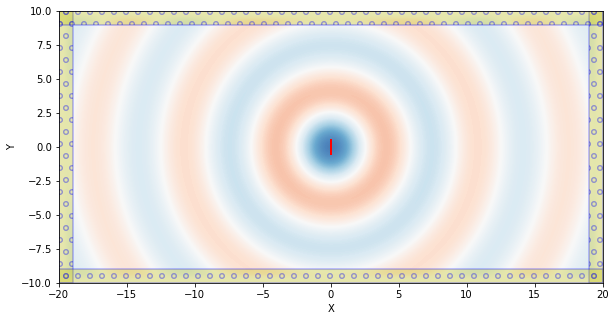

In [7]:
#Runs simulation and save animation of Ez
animate = mp.Animate2D(sim,
                       normalize=True,
                       fields=mp.Ez,
                       realtime=False,
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})


sim.run(mp.at_every(1,animate), until=250)

animate.to_mp4(10, "Ez.mp4")

In [8]:
Video("Ez.mp4")

In [9]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
print(eps_data.shape)

(800, 400)


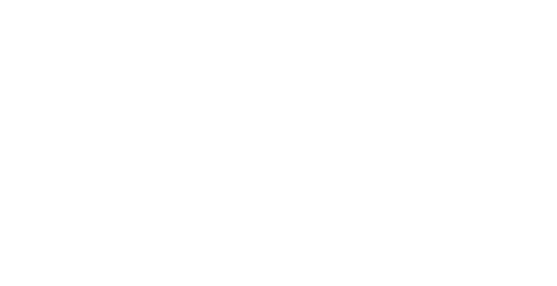

In [10]:
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary', origin="lower")
plt.axis('off')
plt.show()

In [11]:
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
print(ez_data.shape)

(800, 400)


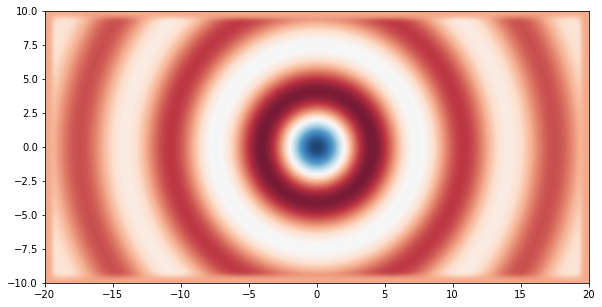

In [12]:
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary', origin="lower", extent=[-sx/2,sx/2,-sy/2,sy/2])
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9, origin="lower", extent=[-sx/2,sx/2,-sy/2,sy/2])
plt.show()

In [13]:
ez_data_wvg_1 = sim.get_array(center=mp.Vector3(0,0), size=mp.Vector3(sx, 0.01), component=mp.Ez)
print(ez_data_wvg_1.shape)

(800, 2)


In [14]:
x = np.arange(-sx/2, sx/2, 1/resolution)

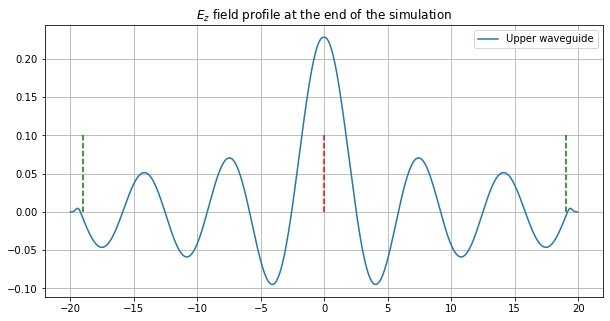

In [15]:
plt.figure()

plt.plot(x, ez_data_wvg_1[:,0], label="Upper waveguide")

plt.vlines(x_source, 0, 0.1, color="red", linestyle="dashed")
plt.vlines([-sx/2 + pml_thickness, sx/2 - pml_thickness], 0, 0.1, color="green", linestyle="dashed")

plt.title(r"$E_z$ field profile at the end of the simulation")
plt.legend()
plt.grid()

# Energy density profiles

In [16]:
energy_data_wvg_1 = sim.get_array(center=mp.Vector3(0,0), size=mp.Vector3(sx, 0.01), component=mp.EnergyDensity)

print(energy_data_wvg_1.shape)

(800, 2)


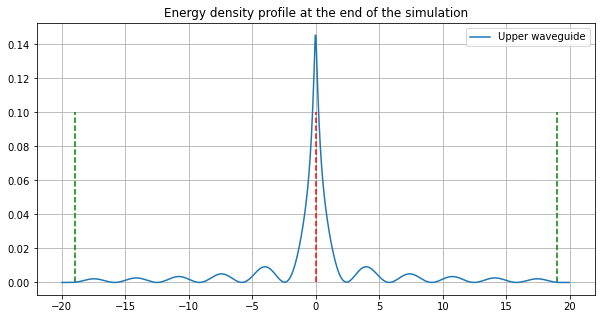

In [17]:
x = np.arange(-sx/2, sx/2, space_res)

plt.figure()

plt.plot(x, energy_data_wvg_1[:,0], label="Upper waveguide")

plt.vlines(x_source, 0, 0.1, color="red", linestyle="dashed")
plt.vlines([-sx/2 + pml_thickness, sx/2 - pml_thickness], 0, 0.1, color="green", linestyle="dashed")

plt.title(r"Energy density profile at the end of the simulation")
plt.legend()
plt.grid()

# Energy density map

# Poynting Vector Map

In [18]:
S_map_x = sim.get_array(center=mp.Vector3(0,0), size=mp.Vector3(sx, sy), component=mp.Sx)
S_map_y = sim.get_array(center=mp.Vector3(0,0), size=mp.Vector3(sx, sy), component=mp.Sy)

print(S_map_x.shape)
print(S_map_y.shape)

(800, 400)
(800, 400)


(400, 800)
(400, 800)
(40, 20)
(40, 20)
(40, 20)
(40, 20)


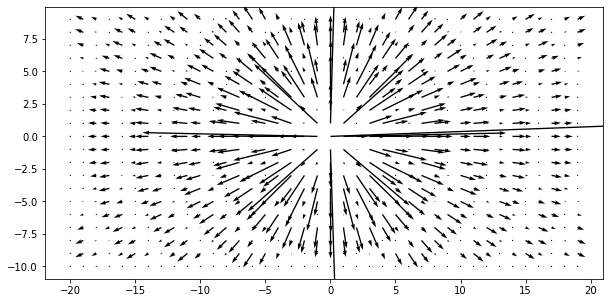

In [23]:
x,y = np.meshgrid(np.arange(-sx/2,sx/2,space_res),np.arange(-sy/2,sy/2,space_res))

drawing_step = 20

print(x.shape)
print(y.shape)

type(x)

print(x[0::drawing_step,0::drawing_step].transpose().shape)
print(y[0::drawing_step,0::drawing_step].transpose().shape)

print(S_map_x[0::drawing_step,0::drawing_step].shape)
print(S_map_y[0::drawing_step,0::drawing_step].shape)



u = 1
v = -1

plt.quiver(x[0::drawing_step,0::drawing_step].transpose(),y[0::drawing_step,0::drawing_step].transpose(),S_map_x[0::drawing_step,0::drawing_step],S_map_y[0::drawing_step,0::drawing_step])
plt.show()  